В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в формате **vowpal wabbit**

В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются **две модальности:**
- Текстовая (```"text"```)
- Мдальность авторов (```"author"```)...у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [100]:
import artm
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import warnings 

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("whitegrid", {'axes.grid' : False})

### Считывание данных
Создайте объект класса ```artm.BatchVectorizer```, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре ```target_folder```. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

Коллекция в vowpal_wabbit- формате — это текстовый документ, в котором отдельная строчка соответствует отдельному документу. Вначале может идти название документа, но в нашей коллекции названий документов нет. Затем идет вертикальная черта, после которой мы пишем название класса или модальности. Для простоты в нашей модели будет только одна модальность — текстовая. Мы ее так и назовем — текст. Затем через пробел идут отдельные слова. После слова может стоять двоеточие и количество раз, сколько оно встретилось в данный момент. Когда BigARTM будет считывать данные, он посчитает суммарное количество раз, сколько слово встретилось в документе, и запишет в матрицу частоту слов. Матрицу частоту слов BigARTM представляет в своем внутреннем формате, называемом батчами. Батчи — это несколько отдельных файлов

BigARTM гораздо быстрее загружает данные уже из батчей, а не из текстового файла. Поэтому если вы захотите строить модель снова на этих же данных, то вам уже можно будет загрузить их прямо из батчей

Когда мы обучим эту модель, мы получим две матрицы — фи и тета. Матрица фи — это матрица распределений слов в темах, а матрица тета — матрица распределения тем в документах. Первая позволяет понять, о чем наши темы, какие слова в нее входят, а вторая — о чем документы, какие темы входят в наши документы.

In [83]:
cd C:\Users\vlad\1. Machine Learning\Yandex Specialization\3.Unsupervised Learning\data

C:\Users\vlad\1. Machine Learning\Yandex Specialization\3.Unsupervised Learning\data


In [84]:
# Создаем Батчи
batch_vectorizer = artm.BatchVectorizer(data_path='lectures.txt', 
                                        data_format='vowpal_wabbit', 
                                        target_folder='lectures_batches',
                                        batch_size=100,
                                        gather_dictionary=True)

### Инициализация модели

Создайте объект класса ```artm.Model``` с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [85]:
# Количество тем
T = 30

# Имена тем 
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]

# Создаем модель. Модальности и веса задаем в параметре class_ids
artm_model = artm.ARTM(num_topics=T,
                       topic_names=topic_names,
                       class_ids={'text':1, 'author':1},
                       seed=1,
                       cache_theta=True,
                       reuse_theta=True
                       )

### Добавление score

Создайте два измерителя качества ```artm.TopTokensScore``` по одному для каждой модальности с параметрами:
- ```num_tokens=15```
- ```name``` (произвольоне)

По данным метрикам мы споможе понять о чем тема.

In [86]:
# Метрики 
top_words = artm.TopTokensScore(name='top_words',
                                class_id='text',
                                num_tokens=15)

top_authors = artm.TopTokensScore(name='top_authors',
                                  class_id='author',
                                  num_tokens=15)

### Cглаживающий и разреживающий регуляризаторы
Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметных тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом: 
- ```artm.SmoothSparsePhiRegularizer:``` Если коэффициент ```tau``` положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Добавьте сглаживающий регуляризатор с параметрами:
- ```tau=1e5```
- ```dictionary=наш словарь```
- ```class_ids='text'```
- ```topic_names='bcg'```

In [87]:
# Создаем сглаживающий регуляризатор 
smooth_reg = artm.SmoothSparsePhiRegularizer(name='back_ground_topic_reg',
                                             tau=1e5,
                                             dictionary=batch_vectorizer.dictionary,
                                             class_ids='text',
                                             topic_names='bcg')

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода ```gather_dictionary``` и инициализируйте модель, указав ```random_seed=1```. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

Оказывается, использовать метод ```gather_dictionary``` не нужно, т.к. теперь при инициализации ```batch_vectorizer``` dictionary собирается автоматически (параметр ```gather_dictionary=True```)

При инициализации модели artm пройдет по всем батчам, в которых хранятся наши данные, и загрузит их в свой словарь. В процессе инициализации создадутся две матрицы (фи и тета) и заполнятся случайными значениями.

In [88]:
# Добавляем созданные метрики и регуляризатор в модель 
artm_model.scores.add(top_words)
artm_model.scores.add(top_authors)
artm_model.regularizers.add(smooth_reg)

# Инициализируем модель, передав наш словарь
artm_model.initialize(batch_vectorizer.dictionary)

Для обучения модели в BigARTM есть два метода. Это ```fit_offline``` и ```fit_online.``` На маленьких коллекциях удобно использовать offline-обучение. Есть ряд параметров которые должны быть заполнены:
- ```num_collection_passes``` - сколько раз нужно пройтись по всей коллекции
- ```num_document_passes``` - сколько раз нужно пройтись по каждому документу

Модель можно обучать с помощью метода ```fit_online```. Он проходит по коллекции гораздо меньшее количество раз, например, один или два. Но приходится настраивать некоторые дополнительные параметры сглаживания. Это удобно для больших коллекций, на которых сделать много проходов по коллекции просто долго.

Выполните 30 итераций по коллекции ```num_collection_passes```, количество внутренних итераций установите равным 1. Используйте метод ```fit_offline``` модели.

In [89]:
# Обучаем модель методом fit_offline
artm_model.num_document_passes = 1
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом ```tau=-1e5```, указав название своего словаря, модальность текста в ```class_ids``` и все темы ```"sbjX"``` в ```topic_names.```

In [90]:
# Добавляем только темы sbjX и разреживающий регуляризатор 
topic_names_cleared = topic_names[:-1]

sparse_reg = artm.SmoothSparsePhiRegularizer(name='subj_topic_reg',
                                             tau=-1e5,
                                             dictionary=batch_vectorizer.dictionary,
                                             class_ids='text',
                                             topic_names=topic_names_cleared)

artm_model.regularizers.add(sparse_reg)

Выполните еще 15 проходов по коллекции.

In [91]:
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [92]:
# Создадим функцию для удобного вывода
def show_tops(model, top_param='top_words'):
    topics = [topic for topic in model.topic_names]
    tokens = model.score_tracker[top_param].last_tokens

    for topic in topics:
        print(topic+':'+ str(tokens[topic]))
        print()
        
show_tops(artm_model, top_param='top_words')

sbj0:['частица', 'взаимодействие', 'физика', 'кварк', 'симметрия', 'элементарный', 'нейтрино', 'стандартный', 'материя', 'протон', 'бозон', 'заряд', 'масса', 'ускоритель', 'слабый']

sbj1:['материал', 'температура', 'структура', 'вещество', 'химический', 'соединение', 'свойство', 'поверхность', 'химия', 'давление', 'углерод', 'сверхпроводимость', 'металл', 'применение', 'полимер']

sbj2:['политический', 'государство', 'политика', 'царь', 'партия', 'власть', 'правитель', 'враг', 'сага', 'кризис', 'ритуал', 'шмитт', 'государь', 'средневековый', 'египетский']

sbj3:['знание', 'университет', 'образование', 'школа', 'предмет', 'восприятие', 'познание', 'факультет', 'аргумент', 'студент', 'логика', 'кафедра', 'прикладной', 'концепт', 'гумбольдт']

sbj4:['мозг', 'ребенок', 'нейрон', 'мышление', 'предложение', 'категория', 'взрослый', 'чтение', 'лицо', 'синтаксический', 'синтаксис', 'устный', 'обезьяна', 'детство', 'словосочетание']

sbj5:['бог', 'миф', 'греческий', 'герой', 'море', 'мифология

In [93]:
show_tops(artm_model, top_param='top_authors')

sbj0:['Дмитрий_Казаков', 'Михаил_Данилов', 'Сергей_Майоров', 'Виктор_Брагута', 'Павел_Пахлов', 'Игорь_Волобуев', 'Валерий_Рубаков', 'Сергей_Троицкий', 'Лев_Дудко', 'Лев_Беклемишев', 'Анатолий_Лиходед', 'Эдуард_Боос', 'Дэвид_Гросс', 'Жан-Арыс_Джилкибаев', 'Аркадий_Цейтлин']

sbj1:['Артем_Оганов', 'Валерий_Фокин', 'Дмитрий_Паращук', 'Валентин_Ненайденко', 'Владимир_Пудалов', 'Валентин_Крапошин', 'Евгений_Гудилин', 'Дмитрий_Гольберг', 'Иван_Сорокин', 'Наталья_Берлофф', 'Сергей_Морозов', 'Евгений_Антипов', 'Вадим_Бражкин', 'Владимир_Комлев', 'Алексей_Кавокин']

sbj2:['Алексей_Юдин', 'Михаил_Бойцов', 'Дина_Гусейнова', 'Иван_Ладынин', 'Андрей_Лукашов', 'Татьяна_Смоктунович', 'Зоригто_Намсараев', 'Владимир_Малахов', 'Кирилл_Мартынов', 'Руслан_Хестанов', 'Ольга_Тогоева', 'Фёдор_Успенский', 'Юрий_Рогулёв', 'Владимир_Кузнецов', 'Александр_Филиппов']

sbj3:['Виктор_Вахштайн', 'Наталья_Ростиславлева', 'Татьяна_Клячко', 'Григорий_Крейдлин', 'Максим_Демин', 'Дмитрий_Балалыкин', 'Сергей_Зенкин', 'Але

В последней теме ```"bcg"``` должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную ```sbj_topic_labels```. В переменной ```topic_labels``` будут храниться названия всех тем, включая фоновую.

In [94]:
# Названия Тем
sbj_topic_labels = ['Физика Элементарных Частиц', 'Технологии Создания Материалов', 'Жизненные Рассказы',
'Интеллектуальное Развитие', 'Решение Задач', 'Жизненное Познание', 'История Героев', 'Люди и Политика',
'Право и Закон', 'Болезни', 'Процессы в Мозге', 'Системные процессы', 'Государство и История',
'Социология и Общество', 'Космос', 'Государство и Экономика', 'Общественные Вопросы', 'Искуственный Интеллект',
'Древняя Письменность', 'Микробиология', 'Квантовая Физика', 'Человек и Философия', 'Политика и Революция',
'Достижения России', 'Современная Литература', 'Физика и Пространство', 'Частицы', 'Действия', 'Образы Правителей']

# Все темы
topic_labels = sbj_topic_labels + ["Фоновая тема"]

### Анализ тем
Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов ```get_phi``` и ```get_theta``` модели. Назовите переменные ```theta``` и ```phi_a```. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [95]:
artm_model.theta_columns_naming = "title" 
theta = artm_model.get_theta()
print('Theta shape: %s' % str(theta.shape))

phi_a = artm_model.get_phi(class_ids='author')
print('Phi_a shape: %s' % str(phi_a.shape))

Theta shape: (30, 1728)
Phi_a shape: (539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

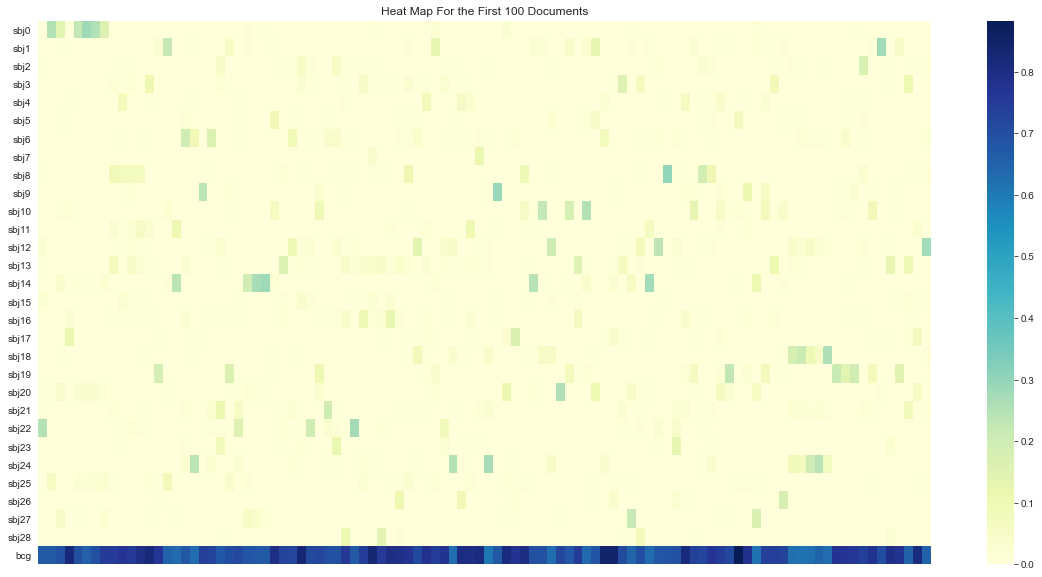

In [103]:
plt.figure(figsize=(20,10))
plt.title('Heat Map For the First 100 Documents (Theta Matrix)')
sns.heatmap(theta.iloc[:, :100], cmap='YlGnBu', xticklabels=False);

Вы должны увидеть, что **фоновая тема имеет большую вероятность в почти каждом документе**, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов про науку в целом, а каждый документ в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [121]:
# Получим вектор вероятностей тем
prob_theme = np.array([theta.iloc[indx].sum() for indx in range(theta.shape[0])])

# Нормируем полученный вектор 
prob_theme_normed = prob_theme/np.sum(prob_theme)

# Создаем необходимы DataFrame
prob_theme_df = pd.DataFrame(prob_theme_normed,index=topic_labels, columns=['theme_prob'])
prob_theme_df.head()

,theme_prob
Физика Элементарных Частиц,0.009680
Технологии Создания Материалов,0.014885
Жизненные Рассказы,0.009870
Интеллектуальное Развитие,0.006364
Решение Задач,0.006584


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [125]:
# Топ-5 самых распространненых тем
prob_theme_df['theme_prob'].sort_values(ascending=False)[:3]

Фоновая тема             0.661600
Социология и Общество    0.049533
Микробиология            0.021597
Name: theme_prob, dtype: float32

In [126]:
# Топ-3 самых нераспространненых тем
prob_theme_df['theme_prob'].sort_values(ascending=True)[:3]

Частицы               0.003080
Люди и Политика       0.004714
Системные процессы    0.005457
Name: theme_prob, dtype: float32

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

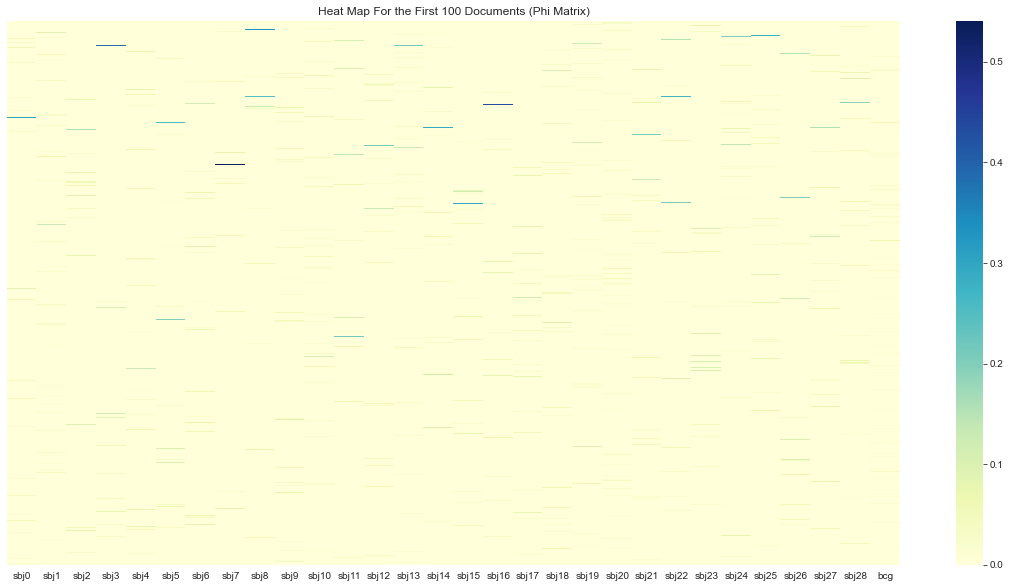

In [127]:
plt.figure(figsize=(20,10))
plt.title('Heat Map For the First 100 Documents (Phi Matrix)')
sns.heatmap(phi_a.iloc[:, :100], cmap='YlGnBu', yticklabels=False);

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [210]:
print('Всего Авторов: ', phi_a.shape[0]) 
significant_authors = {}

# Найдем только значимых авторов и число тем в которых они значимы
for author_indx in range(phi_a.shape[0]):
    theme_cnt = 0
    for theme_prob in phi_a.iloc[author_indx]:
        if theme_prob > 0.01:
            theme_cnt += 1
         
            # Если автор значим, то добавляем его в словарь значимых авторов с указанием значимых тем
            significant_authors[phi_a.index[author_indx][1]] = theme_cnt
            
print('Чилсло Значимых Авторов: ', len(significant_authors))

ordinary_authors = []
for author, score in significant_authors.items():
     if score == 1:
        res = author+' '+str(score)
        ordinary_authors.append(res)
print('Число авторов значимых в 1 теме: ', len(ordinary_authors))

Всего Авторов:  539
Чилсло Значимых Авторов:  491
Число авторов значимых в 1 теме:  417


In [193]:
# Теперь найдем авторов рекордсменов (значимых тем >= 3)
record_authors = []
for author, score in significant_authors.items():
    if score >= 3:
        res = author+' '+str(score)
        record_authors.append(res)
   
print('Авторы Рекордсмены:')
for author in record_authors:
    print('\t'+author)

Авторы Рекордсмены:
	Фёдор_Успенский 4
	Илья_Иткин 4
	Олег_Ауров 3
	Ольга_Вайнштейн 3
	Андрей_Журавлев 3
	Александр_Пиперски 4


Большинство авторов значимы в 1 теме, что логично.

### Построение тематической карты авторов
По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с ```n_components=2```. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [212]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [216]:
# Находим матрицу тематических профилей авторов, используя ф. Байеса
prob_theme_author = np.empty(phi_a.shape)
for i in range(prob_theme_author.shape[0]):
    for j in range(prob_theme_author.shape[1]):
        prob_theme_author[i, j] = phi_a.iloc[i,j]*prob_theme_df.iloc[j, :] / np.sum(phi_a.iloc[i,:] * prob_theme_df['theme_prob'].values)

In [218]:
# Понижаем размерность
similarities = pairwise_distances(prob_theme_author, metric='cosine')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(similarities)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

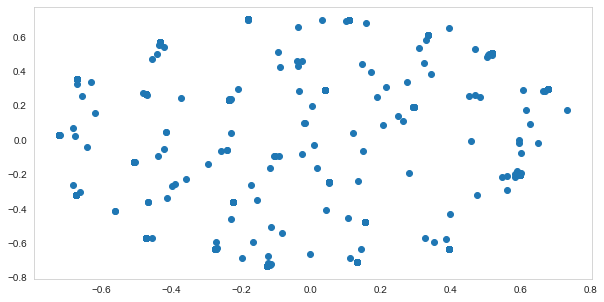

In [220]:
plt.figure(figsize=(10,5))
plt.scatter(pos[:,0], pos[:,1])
plt.show();

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

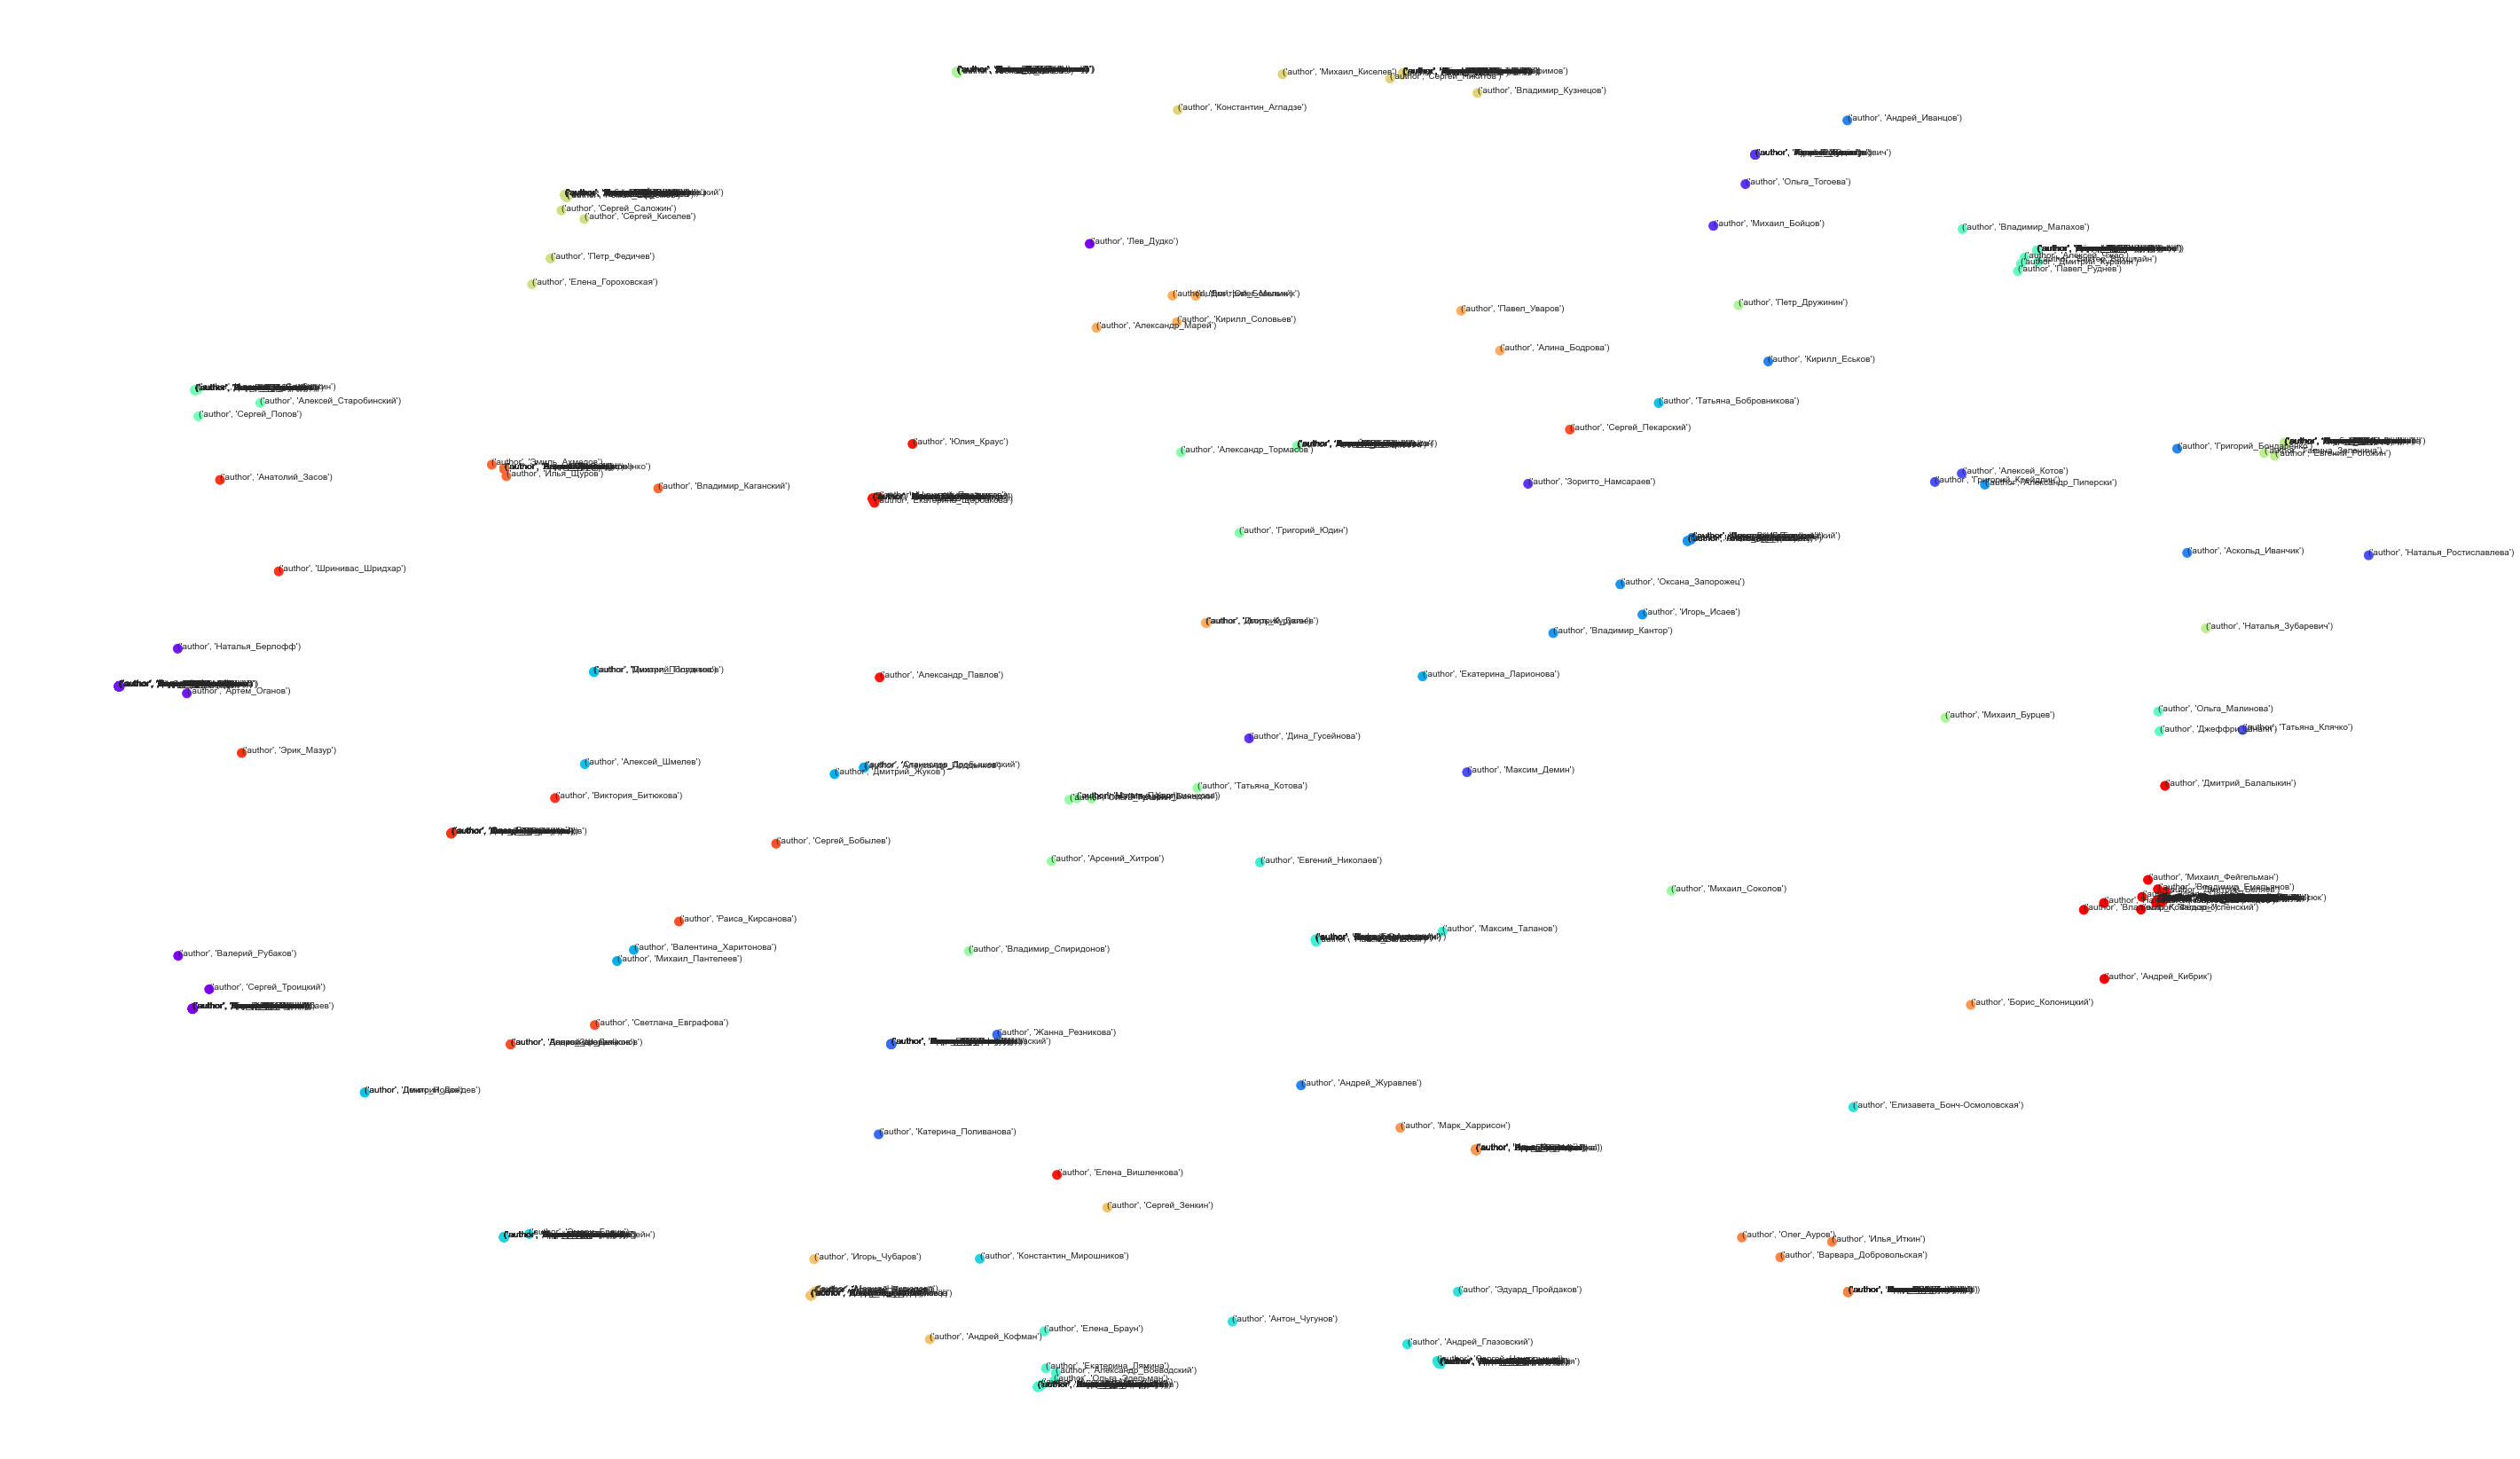

In [232]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем

max_theme_prob_for_colors = [np.argmax(author) for author in prob_theme_author]
plt.figure(figsize=(50, 30))
plt.axis('off')
plt.scatter(pos[:,0], pos[:,1], s=100, c=colors[max_theme_prob_for_colors])
for i, author in enumerate(phi_a.index):
        plt.annotate(author, pos[i])
plt.savefig('authors_map.pdf', dpi=200, format='pdf')
plt.show();

### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [225]:
prob_doc_theme = theta.values / np.array([np.sum(theme) for theme in theta.values])[:, np.newaxis]
prob_doc_theme_sorted_indices = prob_doc_theme.argsort(axis=1)[:,::-1]
prob_doc_theme_sorted_indices

array([[ 926,  793,  794, ..., 1053, 1054,  863],
       [1516,  645,  477, ..., 1006, 1007,  863],
       [1693, 1086, 1280, ...,  851,  852,  863],
       ...,
       [1647, 1141, 1487, ...,  546,  545,  863],
       [1653, 1223,  851, ..., 1165, 1166,  863],
       [1067,   78,  146, ..., 1220, 1191,  218]], dtype=int64)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [227]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [229]:
for i, theme in enumerate(topic_labels):
    display(HTML("<h3>%s</h3>" % theme))
    for j in range(10):
        print(tokens[artm_model.topic_names[i]][j]),
    print('')
    for k in range(10):
        print(theta.columns[prob_doc_theme_sorted_indices[i,k]])

теория
частица
модель
взаимодействие
три
состоять
физика
сила
кварк
сильный

http://postnauka.ru/video/13043
http://postnauka.ru/video/18870
http://postnauka.ru/video/18873
http://postnauka.ru/video/47950
http://postnauka.ru/video/2945
http://postnauka.ru/video/11634
http://postnauka.ru/video/1894
http://postnauka.ru/video/47175
http://postnauka.ru/video/14282
http://postnauka.ru/video/478


при
получать
структура
материал
использовать
создавать
свойство
высокий
метод
различный

http://postnauka.ru/video/31182
http://postnauka.ru/video/13700
http://postnauka.ru/video/57995
http://postnauka.ru/video/18048
http://postnauka.ru/video/41686
http://postnauka.ru/video/13544
http://postnauka.ru/video/51490
http://postnauka.ru/video/50340
http://postnauka.ru/video/46379
http://postnauka.ru/video/56295


рассказывать
жизнь
сам
некий
концепция
граница
над
американский
занимать
замечательный

http://postnauka.ru/video/5517
http://postnauka.ru/video/5179
http://postnauka.ru/video/32906
http://postnauka.ru/video/13538
http://postnauka.ru/video/52941
http://postnauka.ru/video/32882
http://postnauka.ru/video/12083
http://postnauka.ru/video/56304
http://postnauka.ru/video/59199
http://postnauka.ru/video/53228


понимать
что-то
далее
память
общий
образование
университет
казаться
предмет
школа

http://postnauka.ru/video/2973
http://postnauka.ru/video/31198
http://postnauka.ru/video/19570
http://postnauka.ru/video/35038
http://postnauka.ru/video/55533
http://postnauka.ru/video/49445
http://postnauka.ru/video/40889
http://postnauka.ru/video/55217
http://postnauka.ru/video/50406
http://postnauka.ru/video/3603


задача
решать
получаться
речь
лицо
смотреть
посмотреть
читать
третий
мышление

http://postnauka.ru/video/50793
http://postnauka.ru/video/55068
http://postnauka.ru/video/12521
http://postnauka.ru/video/47548
http://postnauka.ru/video/26207
http://postnauka.ru/video/5178
http://postnauka.ru/video/25891
http://postnauka.ru/video/27965
http://postnauka.ru/video/36350
http://postnauka.ru/video/7767


весь
время
друг
нет
вид
потом
находить
жить
действительно
представление

http://postnauka.ru/video/43664
http://postnauka.ru/video/5181
http://postnauka.ru/video/27831
http://postnauka.ru/video/42796
http://postnauka.ru/video/31990
http://postnauka.ru/video/21637
http://postnauka.ru/video/46427
http://postnauka.ru/video/12527
http://postnauka.ru/video/36716
http://postnauka.ru/video/47300


говорить
конечно
город
место
вот
эпоха
культурный
собственно
городской
никто

http://postnauka.ru/video/13156
http://postnauka.ru/video/51171
http://postnauka.ru/video/8964
http://postnauka.ru/video/24279
http://postnauka.ru/video/48112
http://postnauka.ru/video/24945
http://postnauka.ru/video/47301
http://postnauka.ru/video/57318
http://postnauka.ru/video/23470
http://postnauka.ru/video/10773


человек
ситуация
хотя
степень
вариант
цель
конкретный
ответ
действовать
настоящий

http://postnauka.ru/video/31707
http://postnauka.ru/video/37732
http://postnauka.ru/video/32898
http://postnauka.ru/video/35150
http://postnauka.ru/video/42707
http://postnauka.ru/video/15341
http://postnauka.ru/video/42735
http://postnauka.ru/video/17397
http://postnauka.ru/video/31675
http://postnauka.ru/video/40880


право
кто
здесь
давать
случай
отношение
вещь
правило
действие
закон

http://postnauka.ru/video/9299
http://postnauka.ru/video/38009
http://postnauka.ru/video/34414
http://postnauka.ru/video/49455
http://postnauka.ru/video/17912
http://postnauka.ru/video/16822
http://postnauka.ru/video/42221
http://postnauka.ru/video/31688
http://postnauka.ru/video/31666
http://postnauka.ru/video/17875


проблема
связывать
уровень
либо
состояние
данный
механизм
заболевание
поведение
развиваться

http://postnauka.ru/video/13746
http://postnauka.ru/video/532
http://postnauka.ru/video/7753
http://postnauka.ru/video/11361
http://postnauka.ru/video/12974
http://postnauka.ru/video/2541
http://postnauka.ru/video/49206
http://postnauka.ru/video/11850
http://postnauka.ru/video/45961
http://postnauka.ru/video/51384


область
мозг
условие
изменение
животное
эволюция
вода
робот
влиять
нейрон

http://postnauka.ru/video/9861
http://postnauka.ru/video/30673
http://postnauka.ru/video/8953
http://postnauka.ru/video/2531
http://postnauka.ru/video/32635
http://postnauka.ru/video/7113
http://postnauka.ru/video/19071
http://postnauka.ru/video/25889
http://postnauka.ru/video/49437
http://postnauka.ru/video/10786


система
большой
чем
процесс
объект
видеть
раз
находиться
информация
доктор

http://postnauka.ru/video/9997
http://postnauka.ru/video/56052
http://postnauka.ru/video/54916
http://postnauka.ru/video/57336
http://postnauka.ru/video/37979
http://postnauka.ru/video/27845
http://postnauka.ru/video/38507
http://postnauka.ru/video/3645
http://postnauka.ru/video/17421
http://postnauka.ru/video/23079


век
история
государство
война
исторический
период
после
народ
российский
империя

http://postnauka.ru/video/24034
http://postnauka.ru/video/3348
http://postnauka.ru/video/24039
http://postnauka.ru/video/32637
http://postnauka.ru/video/19574
http://postnauka.ru/video/23900
http://postnauka.ru/video/35041
http://postnauka.ru/video/50668
http://postnauka.ru/video/31183
http://postnauka.ru/video/34936


исследование
социальный
понятие
общество
знание
иной
сегодня
научный
заниматься
подход

http://postnauka.ru/video/10783
http://postnauka.ru/video/10749
http://postnauka.ru/video/9148
http://postnauka.ru/video/7778
http://postnauka.ru/video/9870
http://postnauka.ru/video/17491
http://postnauka.ru/video/5878
http://postnauka.ru/video/3417
http://postnauka.ru/video/6380
http://postnauka.ru/video/5198


звезда
галактика
планета
земля
масса
черный
вселенная
скорость
размер
дыра

http://postnauka.ru/video/2971
http://postnauka.ru/video/9835
http://postnauka.ru/video/31193
http://postnauka.ru/video/57338
http://postnauka.ru/video/31695
http://postnauka.ru/video/36249
http://postnauka.ru/video/3604
http://postnauka.ru/video/3423
http://postnauka.ru/video/58744
http://postnauka.ru/video/45644


решение
хотеть
принимать
внимание
проект
экономический
тема
означать
фильм
страна

http://postnauka.ru/video/53415
http://postnauka.ru/video/5465
http://postnauka.ru/video/13152
http://postnauka.ru/video/24286
http://postnauka.ru/video/27823
http://postnauka.ru/video/28278
http://postnauka.ru/video/51488
http://postnauka.ru/video/26119
http://postnauka.ru/video/14280
http://postnauka.ru/video/43679


вопрос
делать
хороший
пытаться
последний
человеческий
предлагать
собственный
способность
кто-то

http://postnauka.ru/video/22892
http://postnauka.ru/video/22883
http://postnauka.ru/video/26223
http://postnauka.ru/video/21643
http://postnauka.ru/video/9865
http://postnauka.ru/video/40866
http://postnauka.ru/video/9729
http://postnauka.ru/video/16191
http://postnauka.ru/video/21661
http://postnauka.ru/video/2946


работать
число
сеть
мой
ошибка
множество
рассматривать
необходимо
сложность
набор

http://postnauka.ru/video/32901
http://postnauka.ru/video/24306
http://postnauka.ru/video/8313
http://postnauka.ru/video/33885
http://postnauka.ru/video/55303
http://postnauka.ru/video/47810
http://postnauka.ru/video/12172
http://postnauka.ru/video/9998
http://postnauka.ru/video/45717
http://postnauka.ru/video/13155


язык
слово
русский
территория
словарь
христианский
восток
владимир
письменность
перевод

http://postnauka.ru/video/53171
http://postnauka.ru/video/5891
http://postnauka.ru/video/59201
http://postnauka.ru/video/2527
http://postnauka.ru/video/12515
http://postnauka.ru/video/17041
http://postnauka.ru/video/51380
http://postnauka.ru/video/25290
http://postnauka.ru/video/52958
http://postnauka.ru/video/56302


клетка
организм
ген
днк
белок
молекула
биологический
болезнь
функция
генетический

http://postnauka.ru/video/5390
http://postnauka.ru/video/10475
http://postnauka.ru/video/17051
http://postnauka.ru/video/27434
http://postnauka.ru/video/32881
http://postnauka.ru/video/35461
http://postnauka.ru/video/35051
http://postnauka.ru/video/5915
http://postnauka.ru/video/16156
http://postnauka.ru/video/11628


энергия
поле
квантовый
свет
эксперимент
атом
эффект
магнитный
волна
электрон

http://postnauka.ru/video/19457
http://postnauka.ru/video/21662
http://postnauka.ru/video/25875
http://postnauka.ru/video/24434
http://postnauka.ru/video/19509
http://postnauka.ru/video/51174
http://postnauka.ru/video/3381
http://postnauka.ru/video/23335
http://postnauka.ru/video/26609
http://postnauka.ru/video/18221


культура
смысл
книга
ребенок
философия
принцип
женщина
философский
семья
понимание

http://postnauka.ru/video/2529
http://postnauka.ru/video/12738
http://postnauka.ru/video/7764
http://postnauka.ru/video/9728
http://postnauka.ru/video/53513
http://postnauka.ru/video/23834
http://postnauka.ru/video/32664
http://postnauka.ru/video/7068
http://postnauka.ru/video/46317
http://postnauka.ru/video/37965


его
политический
власть
идея
революция
писать
политика
начинаться
бог
страна

http://postnauka.ru/video/53577
http://postnauka.ru/video/48492
http://postnauka.ru/video/54175
http://postnauka.ru/video/47823
http://postnauka.ru/video/1893
http://postnauka.ru/video/25882
http://postnauka.ru/video/42993
http://postnauka.ru/video/58542
http://postnauka.ru/video/23161
http://postnauka.ru/video/50656


первый
становиться
россия
советский
считать
поскольку
род
причина
проводить
программа

http://postnauka.ru/video/34413
http://postnauka.ru/video/30261
http://postnauka.ru/video/46939
http://postnauka.ru/video/52936
http://postnauka.ru/video/57259
http://postnauka.ru/video/41680
http://postnauka.ru/video/25890
http://postnauka.ru/video/55219
http://postnauka.ru/video/47816
http://postnauka.ru/video/25906


наука
мир
современный
текст
форма
кандидат
многий
традиция
особенность
главный

http://postnauka.ru/video/7755
http://postnauka.ru/video/13041
http://postnauka.ru/video/10473
http://postnauka.ru/video/55301
http://postnauka.ru/video/52778
http://postnauka.ru/video/3387
http://postnauka.ru/video/14297
http://postnauka.ru/video/53169
http://postnauka.ru/video/49203
http://postnauka.ru/video/16157


какой-то
оказываться
группа
пространство
описывать
простой
классический
движение
следующий
специальный

http://postnauka.ru/video/3388
http://postnauka.ru/video/36804
http://postnauka.ru/video/57128
http://postnauka.ru/video/55069
http://postnauka.ru/video/18085
http://postnauka.ru/video/18086
http://postnauka.ru/video/19456
http://postnauka.ru/video/51371
http://postnauka.ru/video/25278
http://postnauka.ru/video/34416


часть
появляться
достаточно
оно
данные
часто
значение
нужный
анализ
скажем

http://postnauka.ru/video/9389
http://postnauka.ru/video/31684
http://postnauka.ru/video/43843
http://postnauka.ru/video/49866
http://postnauka.ru/video/40004
http://postnauka.ru/video/37978
http://postnauka.ru/video/36242
http://postnauka.ru/video/57127
http://postnauka.ru/video/30601
http://postnauka.ru/video/26616


мочь
один
наш
иметь
два
разный
более
несколько
количество
тип

http://postnauka.ru/video/53693
http://postnauka.ru/video/6673
http://postnauka.ru/video/30015
http://postnauka.ru/video/59202
http://postnauka.ru/video/23969
http://postnauka.ru/video/49447
http://postnauka.ru/video/10756
http://postnauka.ru/video/12372
http://postnauka.ru/video/38007
http://postnauka.ru/video/23500


какой
образ
развитие
роль
конец
любой
начало
ученый
зрение
каков

http://postnauka.ru/video/5396
http://postnauka.ru/video/9429
http://postnauka.ru/video/10779
http://postnauka.ru/video/39723
http://postnauka.ru/video/11246
http://postnauka.ru/video/8623
http://postnauka.ru/video/7074
http://postnauka.ru/video/57126
http://postnauka.ru/video/19436
http://postnauka.ru/video/45548


быть
что
это
который
этот
как
они
такой
очень
для

http://postnauka.ru/video/51365
http://postnauka.ru/video/49851
http://postnauka.ru/video/42436
http://postnauka.ru/video/54112
http://postnauka.ru/video/58752
http://postnauka.ru/video/54668
http://postnauka.ru/video/41678
http://postnauka.ru/video/46943
http://postnauka.ru/video/51494
http://postnauka.ru/video/36857


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 